In [3]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

from cmbml.utils.handle_data import get_planck_noise_data, get_planck_obs_data

In [2]:
DATA_ROOT = "/data/jim/CMB_Data/"
ASSETS_DIRECTORY = f"{DATA_ROOT}/Assets/Planck/"
PLANCK_NOISE_DIR = f"{DATA_ROOT}/Assets/PlanckNoise/"

DET = 545

In [3]:
def plot_many_ps(ps_s,
            title=None, 
            x_low=0.7,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e-2,
            styles=None,
            labels=None,
            white_noise_expected=None,
            legend=True,
            focus_first=False):
    y_label="$N_{\\ell}$" + f"(unit)"
    x_label="$\\ell$"
    plt.figure()
    for i, ps in enumerate(ps_s):
        ells = np.arange(len(ps)).astype(float)
        if x_low < 1:
            ells[0] = x_low
        style=None
        linewidth=None
        color=None
        if styles is None:
            pass
        elif styles[i] != "-":
            style = styles[i]
            linewidth = 2
        else:
            style = styles[i]
            linewidth = 1
        if focus_first and i == 0:
            color='black'
            linewidth=3
        label = None if labels is None else labels[i]
        plt.plot(ells, ps, label=label, linestyle=style, color=color, linewidth=linewidth)
    # if white_noise_expected is not None:
    #     plt.axhline(y=white_noise_expected, color='black', linestyle='--', linewidth=1)
    #     plt.text(y=white_noise_expected, x=x_high, s="$\\sigma_{\\ell}=" + f"{white_noise_expected:.1e}$", 
    #              color='black',
    #              horizontalalignment='right', verticalalignment='bottom')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([x_low-0.00001, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

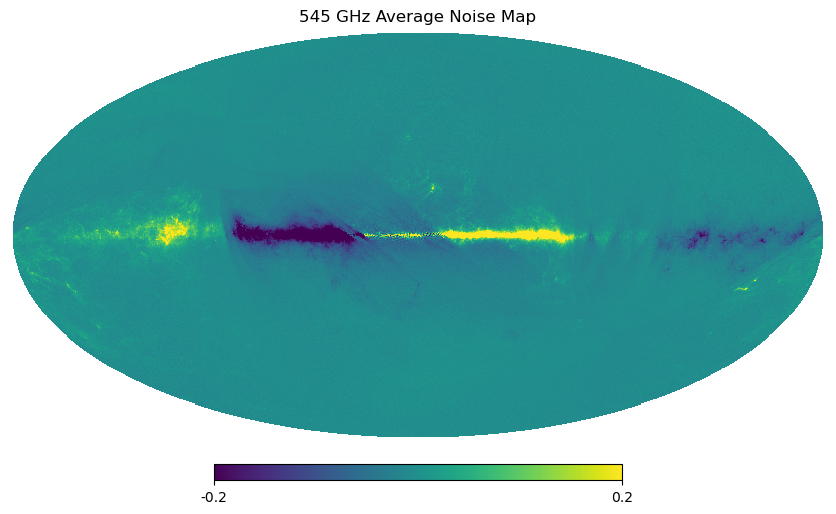

In [16]:
fn = f"noise_avgs/avg_noise_map_{DET}_TQU_100.fits"
nse_avg = hp.read_map(fn)
hp.mollview(nse_avg, title=f"{DET} GHz Average Noise Map", min=-0.20, max=0.20)

In [6]:
# Make simple galactic mask
galactic_mask = np.zeros(hp.nside2npix(2048))
galactic_mask[hp.query_strip(2048, np.radians(85), np.radians(95))] = 1

In [7]:
galactic_mask_sm = hp.smoothing(galactic_mask, fwhm=np.radians(10/60))  #, nest=True)

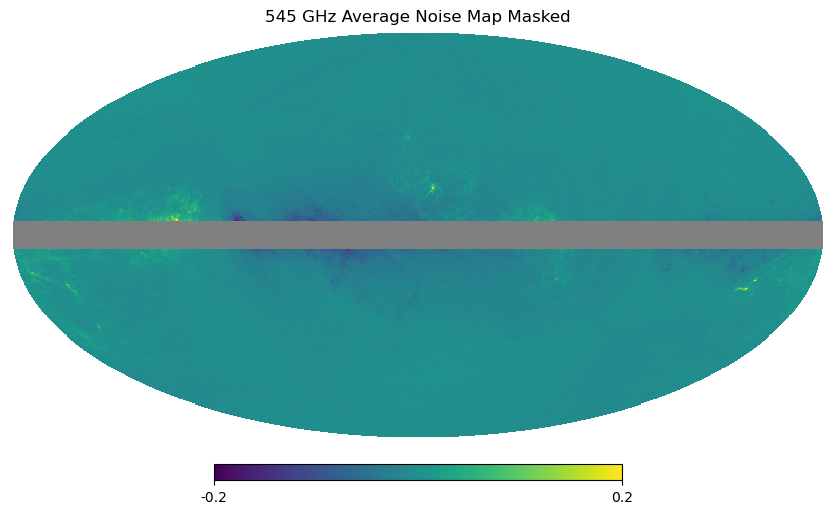

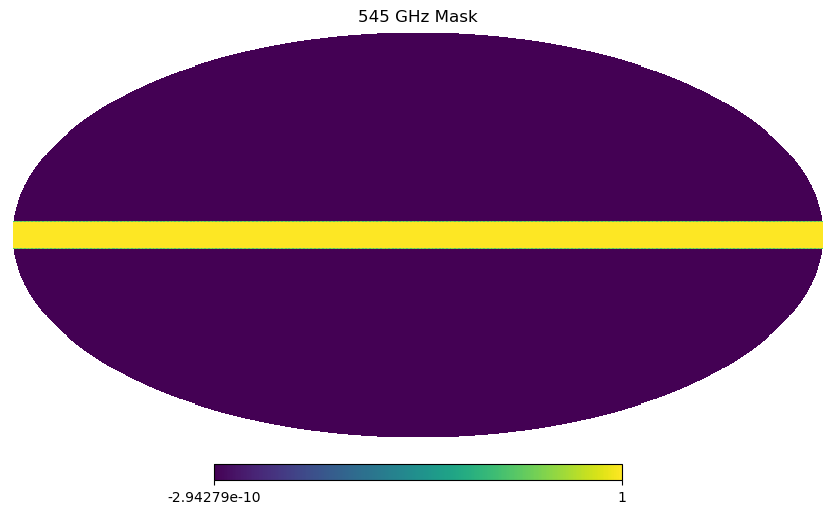

In [28]:
avg_nse_masked = nse_avg.copy()
avg_nse_masked = hp.ma(avg_nse_masked)
avg_nse_masked.mask = galactic_mask
hp.mollview(avg_nse_masked, title=f"{DET} GHz Average Noise Map Masked", min=-.2, max=.2)
hp.mollview(galactic_mask_sm, title=f"{DET} GHz Mask")

In [8]:
nside = hp.get_nside(nse_avg)
lmax = 3*nside - 1

In [4]:
cl_nomask = hp.anafast(nse_avg, lmax=lmax)  # Why twice as fast? Because we're not doing cross-correlation?

NameError: name 'nse_avg' is not defined

In [10]:
def get_autopower(map_, mask, lmax):
    return get_xpower(map1=map_, map2=None, mask=mask, lmax=lmax)

def get_xpower(map1, map2, mask, lmax, use_pixel_weights=False):
    if mask is None:
        ps = hp.anafast(map1, map2, lmax=lmax, use_pixel_weights=use_pixel_weights)
    else:
        mean1 = np.sum(map1*mask)/np.sum(mask)
        input1 = mask*(map1-mean1)
        if map2 is None:
            input2 = None
        else:
            mean2 = np.sum(map2*mask)/np.sum(mask)
            input2 = mask*(map2-mean2)
        fsky = np.sum(mask)/mask.shape[0]
        ps = hp.anafast(input1,
                        input2,
                        lmax=lmax,
                        use_pixel_weights=use_pixel_weights)
        ps = ps / fsky
    return ps

In [9]:
fsky = np.sum(galactic_mask_sm)/galactic_mask_sm.shape[0]
fsky

0.08707682264839423

In [11]:
1/0
cl_nomask = get_autopower(nse_avg, mask=None, lmax=lmax)

ZeroDivisionError: division by zero

In [12]:
cl_masked = get_autopower(nse_avg, mask=np.logical_not(galactic_mask), lmax=lmax)

In [13]:
cl_masked_sm = get_autopower(nse_avg, mask=np.logical_not(galactic_mask), lmax=lmax)

In [ ]:
plot_many_ps([
              cl_nomask,
              cl_masked,
              cl_masked_sm
             ],
             labels=[
                 "Average Noise",
                 "Average Noise Masked",
                 "Average Noise Masked Smoothed"
             ],
             title=f"{DET} GHz Noise Power Spectrum",
             y_low=1e-17,
             y_high=None,
             focus_first=True)